In [1]:
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

%precision %.2f

'%.2f'

In [2]:
x = [0.0,
3.00,
6.00,
7.50,
7.50,
9.00,
12.0,
13.5,
13.5,
15.0,
18.0,
18,
21
]

sref = [0.00
,54.79
,92.13
,127.28
,39.78
,78.84
,180.60
,237.34
,149.84
,210.51
,343.57
,0
,0
]

mref = [0.00
,93.57
,345.83
,534.34
,665.59
,769.91
,1214.65
,1573.74
,1748.74
,2060.92
,3012.74
,3012.74
,3012.74
]

tref = [0.00
,2.31
,6.14
,8.74
,-218.59
,-215.47
,-207.50
,-202.53
,-505.64
,-499.97
,-486.33
,-486.33
,-486.33
]

df = pd.DataFrame()
df['x'] = x
df['sref'] = sref
df['mref'] = mref
df['tref'] = tref

df

,x,sref,mref,tref
0,0.0,0.00,0.00,0.00
1,3.0,54.79,93.57,2.31
2,6.0,92.13,345.83,6.14
3,7.5,127.28,534.34,8.74
4,7.5,39.78,665.59,-218.59
5,9.0,78.84,769.91,-215.47
6,12.0,180.60,1214.65,-207.50
7,13.5,237.34,1573.74,-202.53
8,13.5,149.84,1748.74,-505.64
9,15.0,210.51,2060.92,-499.97


In [3]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 12

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"]})

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
#sns.set_theme()
sns.set_style("ticks")

%matplotlib inline

In [5]:
def plot_data(y, label, title, unit = 'kNm', y0 = 0):
    fig = plt.figure(figsize=(6,5))
    ax = plt.subplot(111)
    plt.plot(df.x, y, 'x-', linewidth=1)
    #plt.title(f'{title} Variation Along Wing Reference Axis.', fontname = 'Computer Modern')
    plt.xlabel(r'$x \;\: (m)$')
    plt.ylabel(f'${label}_{{REF}} \; ({unit})$')
    plt.xlim(left = 0)
    plt.ylim(bottom = y0)
    plt.xticks(np.arange(0, 23, 2))
    #plt.grid(True)
    #ax.spines['bottom'].set_position('zero')
    #ax.spines['left'].set_position('zero')
    #sns.despine(offset=0)
    #if y0 != 0:
    #    plt.axhline(0, color='grey', ls = 'dashed', alpha = 0.5)
    plt.savefig(f'{label}.eps')

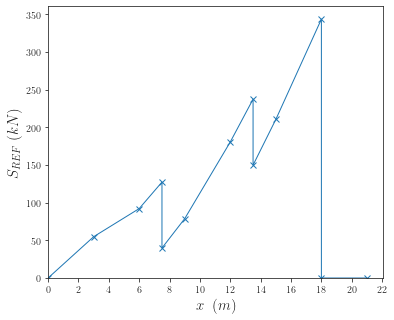

In [6]:
plot_data(df.sref, 'S', 'Shear Force', 'kN')

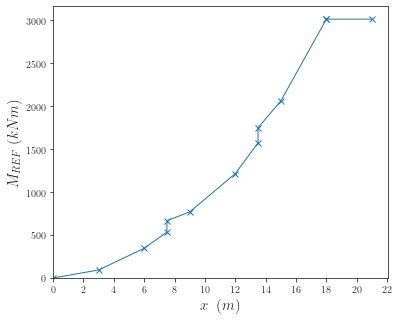

In [7]:
plot_data(df.mref, 'M', 'Bending Moment')

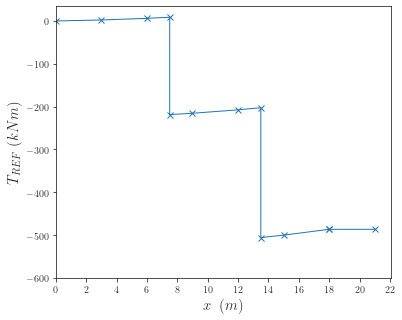

In [8]:
plot_data(df.tref, 'T', 'Torque', y0 = -600)

# Define Values #

In [9]:
Mx = df.mref.tolist()[-4]*1000 #Nm
t_c = 0.1
c = 6.66666667e3 #mm 
cbox = 0.4*c
d = c*t_c #mm

In [10]:
ksk = 2.23
kst = 1.65
#tst = None #mm
#tsk = None #mm
#bsko = None #mm
#bskc = None #mm
bsk = 180 #mm
#bst = None #mm
Esk = 72 #kN/mm2
Est = 88 #kN/mm2

# $N_x = \frac{M_x}{dc_{box}}\cdot 1.5$ #

In [11]:
Nx = 1.5*Mx/(d*cbox)
print(f"Nx = {Nx:.4f} N/mm")

Nx = 1.7389 N/mm


# $ k_{sk}(\frac{t_{st}}{b_{sk,o}})^2 = k_{st}(\frac{t_{sk}}{b_{st}})^2 $ #
# $N_x = N_{sk}$ #

### Want to find: $b_{st}$, $t_{st}$, $t_{sk}$ ###

Optimise for:
- Max Reserve Factor
- Min Mass

By fixing $b_{st}$ 

In [12]:
def axial_stiffness(E_sk, t_sk, E_st, t_st, b_st, b_sk):
    E_t = E_sk*t_sk + E_st*t_st*(2*35+3*b_st)/b_sk
    return E_t

def bl_sk_op(E_t, k_sk, t_sk, b_sk):
    N_sk_op = E_t*k_sk*(t_sk/b_sk)**2
    return N_sk_op

def bl_sk_st(E_t, k_st, t_sk, b_st):
    N_sk_st = E_t*k_st*(t_sk/b_st)**2
    return N_sk_st

def euler_buckling(E_sk, b_sk, t_sk, t_st, E_st, b_st, EI_w_cg, z_bar_w):

    z_bar = sigma_EAZ/sigma_EA

    skin = E_sk*b_sk*z_bar**2 + E_sk*(t_sk**3)/12*b_sk
    flange_3mm = E_sk*2*35*t_st*(z_bar-np.mean([t_st, t_sk]))**2 + 2*E_st*35*(t_st**3)/12
    flange_remote = E_st*t_st*b_st*((np.sqrt(3)/2)*b_st + np.mean([t_st, t_sk]) - z_bar)**2
    webs = 2*EI_w_cg + 2*E_st*b_st*t_st*z_bar_w**2
    
    N_x_euler = np.pi**2*(skin+flange_3mm+flange_remote+webs)/(b_sk*800**2)
    return N_x_euler
    

In [13]:
def step(bst, output = False):
    bskc = bst*(1+2*np.cos(np.pi/3))
    bsko = bsk-bskc

    if output: print(f"bsko = {bsko:.2f}mm\nbskc = {bskc:.2f}mm")

    LHS = np.sqrt(ksk)/max([bsko, bskc])
    RHS = np.sqrt(kst)/bst
    
    if output: print(f"t_st/t_sk = {RHS/LHS:.3f}")

    f1 = LHS/RHS
    f2 = Esk*( f1 + (1/bsk)*(70+3*bst) )

    if output: print(f"f1 = {f1:.2f}")
    if output: print(f"f2 = {f2:.2f}")

    a_sk = (f1/f2) * ksk / max([bsko, bskc])**2
    a_st = f1      * kst / bst**2

    if output: print(f"a_sk = {a_sk}")
    if output: print(f"a_st = {a_st}")

    tst1 = (Nx/a_sk)**(1/3)
    tst2 = (Nx/a_st)**(1/3)

    if output: print(tst1)
    if output: print(tst2)

    return min(tst1, tst2)

def calc_zbar(bst, output = False):
    bskc = bst*(1+2*np.cos(np.pi/3))
    bsko = bsk-bskc

    if output: print(f"bsko = {bsko:.2f}mm\nbskc = {bskc:.2f}mm")

    LHS = np.sqrt(ksk)/max([bsko, bskc])
    RHS = np.sqrt(kst)/bst
    
    if output: print(f"t_st/t_sk = {RHS/LHS:.3f}")

    f1 = LHS/RHS
    f2 = Est*( (1+f1)*(35+bst) + (bst**2)*np.sqrt(3)/4 )
    f3 = Est*bst*( bst*np.sqrt(3)/2 + np.mean([bst, bsk])) #bst*np.sqrt(3)/4 + 
    f4 = Esk*f1*bsk + Est*(3*bst + 70)

    print(f1)
    print(f2)
    print(f3)
    print(f4)
    print()

    print(f2/f4)
    print(f3/f4)
    print((9.44 - f3/f4)/(f2/f4))


In [14]:
tst = 2
tsk = 3
bst = 45
f1 = tsk/tst

EAZ1_0 = 70*tst*np.mean([tst, tsk])*Est
EAZ1 = 35*tst**2*(1+f1)*Est

print(EAZ1_0)
print(EAZ1)

EAZ2_0 = 2*bst*tst*((tsk+tst)/2 + bst*np.sqrt(3)/4)*Est
EAZ2 =   Est*( bst*(1+f1)*tst**2 +  tst*(np.sqrt(3)/2)*bst**2 )

print(EAZ2_0)
print(EAZ2, '\n')

EAZ3_0 = bst*tst*Est*( bst*np.sqrt(3)/2 + tst*(1+f1)/2) # = bst*tst*(bst*np.sqrt(3)/2 + np.mean([bsk, bst]))*Est

print(EAZ3_0)

EAZ = EAZ1+EAZ2+EAZ3_0
print('\n', EAZ, '\n')

denom_0 = Esk*tsk*bsk + Est*tst*(3*bst+70)
denom   = Esk*tst*f1*bsk + Est*tst*(3*bst+70)

print(denom_0)
print(denom)

print(EAZ/denom)

num = tst*(1+f1)*(35 + 1.5*bst) + np.sqrt(3) * bst**2
f4 = (Esk*f1*bsk + Est*(3*bst+70))/Est
f2 = (1+f1) *(35+1.5*bst)
f3 = np.sqrt(3)*bst**2

a1 = f2/f4
a2 = f3/f4

zbar = a1*tst+a2
print(a1, a2, zbar)

b1 = zbar - tst*(1+f1)/2

EI_skin = Esk*(bsk*tsk*zbar**2 + bsk*(f1*tst)**(3)/12)
EI_3mm  = 70*(Esk*tst*(b1)**2 + Est*(tst**3)/12)
EI_r    = Est*(tst*bst*(bst*np.sqrt(3)/2 - b1)**2 + bst*(tst**3)/12)
EI_w    = Est*tst*((bst**3)/8 + 2*bst*(bst*np.sqrt(3)/4 - b1)**2)

EI_tot = EI_skin + EI_3mm + EI_r + EI_w
N_xeuler = np.pi**2/(800**2*bsk) * EI_tot
N_xeuler

print(EI_skin)
print(EI_3mm)
print(EI_r)  
print(EI_w)  



30800.0
30800.0
348251.45390877395
348251.45390877395 

328451.45390877395

 707502.9078175479 

74960
74960.0
9.438405920725025
0.6016542155816436 8.235097489561737 9.438405920725025
3492726.725891785
489372.75201184757
8129322.345146309
4498462.840774666


In [15]:
def factor_calc(bst, others = False):
    bskc = bst*(1+2*np.cos(np.pi/3)) +35
    bsko = bsk-bskc

    # LHS = np.sqrt(ksk)/max([bsko, bskc])
    # RHS = np.sqrt(kst)/bst
    
    # f1 = LHS/RHS

    f1 = np.sqrt(kst/ksk) * (max([bsko, bskc])/bst)

    if not others:
        return f1
    else:
        return f1, bskc, bsko

In [16]:
def calc_Nxeuler(bst, output = False, f1 = None):
    # bskc = bst*(1+2*np.cos(np.pi/3))
    # bsko = bsk-bskc

    # if output: print(f"bsko = {bsko:.2f}mm\nbskc = {bskc:.2f}mm")

    # LHS = np.sqrt(ksk)/max([bsko, bskc])
    # RHS = np.sqrt(kst)/bst
    
    # if output: print(f"t_st/t_sk = {RHS/LHS:.3f}")

    f1 = factor_calc(bst) if f1 is None else f1 #LHS/RHS

    f4 = (Esk*f1*bsk + Est*(3*bst+70))/Est
    f2 = (1+f1) *(35+1.5*bst)
    f3 = np.sqrt(3)*bst**2

    a1 = f2/f4
    a2 = f3/f4

    def Nx(tst):
        zbar = a1*tst+a2
        if output: print(zbar)

        b1 = zbar - tst*(1+f1)/2

        EI_skin = Esk*(bsk*tsk*zbar**2 + bsk*(f1*tst)**(3)/12)
        EI_3mm  = 70*(Esk*tst*(b1)**2 + Est*(tst**3)/12)
        EI_r    = Est*(tst*bst*(bst*np.sqrt(3)/2 - b1)**2 + bst*(tst**3)/12)
        EI_w    = Est*tst*((bst**3)/8 + 2*bst*(bst*np.sqrt(3)/4 - b1)**2)

        EI_tot = EI_skin + EI_3mm + EI_r + EI_w
        N_xeuler = np.pi**2/(800**2*bsk) * EI_tot
        
        if output: print(EI_tot)

        return N_xeuler

    return Nx

In [17]:
def calc_Etbar(bst, tst, f1 = None):
    #f1 = factor_calc(bst)
    f1 = factor_calc(bst) if f1 is None else f1

    Etbar = Esk*f1*tst+Est*tst*(70 + 3*bst)/bsk

    return Etbar

def calc_uts(tst, tsk, bst):
    return 0.0045*(Esk*tsk+Est*tst*(70 + 3*bst)/bsk)

In [18]:
def calc_tst_from_euler(bst):
    safety_factor = 1.2
    f1, bskc, bsko = factor_calc(bst, True)

    # a = Nx * np.max([bskc, bsko])**2
    # b = (f1**2)*ksk*(f1*Esk + (1/bsk)*(70 + 3*bst))
    # tst = (a/b)**(1/3)

    a = Nx * bst**2
    b = kst*(Esk*f1 + Est*(70+3*bst)/bsk)
    tst = (a/b)**(1/3)

    return tst

In [19]:
def calc_tst_from_uts(bst):
    f1 = factor_calc(bst)
    tst = (Nx/0.0045) / (Esk*f1 + Est*(70 + 3*bst)/bsk)
    return tst

In [20]:
def calc_tst(bst):
    euler = calc_tst_from_euler(bst)
    uts = calc_tst_from_uts(bst)
    return max(euler, uts)

In [21]:
def calc_mass(bst):
    f1 = factor_calc(bst)
    tst = calc_tst(bst)
    tsk = f1*tst

    rho = 1600/(1e3**3) #kg/mm^3

    skin    = bsk*tsk   #mm^2
    st_3mm  = 2*35*tst  #mm^2
    st      = 3*bst*tst #mm^2

    mass = (skin+st_3mm+st)*rho #kg/mm
    return mass  


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


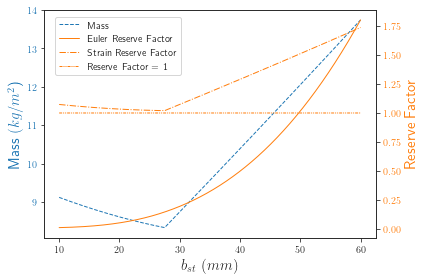

In [22]:
bst = np.arange(10, 60, 0.001)
mass = [1e6*calc_mass(i)/bsk for i in bst]
tst = [calc_tst(i) for i in bst]
reserve = [calc_Nxeuler(i)(j)/(Nx*1.2) for i,j in zip(bst, tst)]
reserve_mat = [(calc_Etbar(i, j)*0.0045)/Nx for i,j in zip(bst, tst)]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel(r'$b_{st}$ $(mm)$')
ax1.set_ylabel(r'Mass $(kg/m^2$)', color=color)
ax1.plot(bst, mass, color=color, linestyle = '--', linewidth = 1, label = 'Mass')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel(r'Reserve Factor', color=color)  # we already handled the x-label with ax1
ax2.plot(bst, reserve, color=color, linewidth = 1, label = 'Euler Reserve Factor')
ax2.plot(bst, reserve_mat, '-.', color=color, linewidth = 1, label = 'Strain Reserve Factor')
ax2.plot(bst, bst*0+1, linestyle = (0, (3, 1, 1, 1, 1, 1)), linewidth = 1, color=color, label = 'Reserve Factor = 1')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

# ax1.spines['bottom'].set_position('zero')
# ax1.spines['left'].set_position('zero')
# ax2.spines['bottom'].set_position('zero')
# ax2.spines['left'].set_position('zero')
#sns.despine(offset=0, right = False)

axbox = ax1.get_position()
fig.legend(loc = (axbox.x0+0.02, axbox.y0+0.57))

plt.savefig(f'opt.eps')

In [23]:
from scipy.optimize import minimize_scalar
min_bst = bst[np.argmin(np.abs(np.array(reserve)-1.2))]
#res = calc_mass(min_bst)#minimize_scalar(calc_mass, bounds = (min_bst, min_bst*2), method = 'Bounded')
best_bst = min_bst
best_tst = calc_tst(min_bst)
best_tsk = factor_calc(min_bst)*best_tst
best_mass = 1e6*calc_mass(min_bst)/bsk
print(f'bst = {best_bst:.2f} mm')
print(f'tst = {best_tst:.2f} mm')
print(f'tsk = {best_tsk:.2f} mm')
print(f'mass = {best_mass:.2f} kg/m^2')

print()

euler_buckling_load = calc_Nxeuler(best_bst)(best_tst)
material_faulire_load = calc_uts(best_tst, best_tsk, best_bst)
print(f"Nx = {Nx:.2f} N/mm")
print(f'UTS = {material_faulire_load:.2f} N/mm')
print(f'Pcr = {euler_buckling_load:.2f} N/mm')

bst = 52.70 mm
tst = 2.20 mm
tsk = 5.03 mm
mass = 12.50 kg/m^2

Nx = 1.74 N/mm
UTS = 2.73 N/mm
Pcr = 2.50 N/mm


In [24]:
print(best_tsk/0.125)
print(best_tst/0.125)

40.252712270216314
17.56487271142449


In [25]:
def cfrp_stiffness(tk, phi = np.array([0, 45, 90]), E = 130):
    cos_4_phi = np.cos(phi * (np.pi/180))**4
    tk_pc = tk/tk.sum()
    return np.sum(tk_pc * cos_4_phi)*E

def dec2bin(x, n = 3):
    x = bin(x)
    b = x + '0'*((n+2)-len(x))
    b = b[2:]
    b = [1-2*int(i) for i in b]
    return b
    

def stack(seq, t_panel, t = 0.125, tolerance = 0.08):
    df = pd.DataFrame(columns=['seq', 'E', 't'])
    seq = np.array(seq)/100
    perfect = seq*t_panel/t

    rounded = np.round(perfect)

    combinations = rounded%2

    allowable_odds = [np.array([0, 0, 1]), np.array([1, 0, 0]), np.array([0, 0, -1]), np.array([-1,0, 0])]

    combinations = [dec2bin(i)*combinations for i in range(8)]
    combinations = combinations + [i * np.array([1, 1, 0]) for i in combinations] +  [i * np.array([0, 1, 1]) for i in combinations]
    for j in allowable_odds:
        combinations = combinations + [j+i for i in combinations]
    combinations = [rounded + i for i in combinations]
    combinations = [i for i in combinations if (not i[1]%2)]
    combinations = [i + np.array([0, 2, 0]) if (i[1]%4) else i for i in combinations] + [i + np.array([0, -2, 0]) if (i[1]%4) else i for i in combinations]
    combinations = [i for i in combinations if not any(i<=0)]
    combinations = [i for i in combinations if i[2] > 2]
    combinations = [i for i in combinations if (not i[0] % 2) or (not i[2] % 2)]
    combinations = [i for i in combinations if i[2]/sum(i) < 17]


    combinations = np.unique(combinations, axis = 0)
    e_combinations = [cfrp_stiffness(i) for i in combinations]
    n_combinations = [sum(i) for i in combinations]
    for i, (x, e, n) in enumerate(zip(combinations, e_combinations, n_combinations)):
        check = x[0]/(x[1]-4 + x[2])
        x_str = '/'.join(str(int(i)) for i in x)
        x_pc = x/x.sum()
        x_pc = [np.round(abs(i-j), 2) for i,j in zip(x_pc[:2], seq[:2])]
        if max(x_pc) < tolerance and check <= 6:
            df = df.append(pd.DataFrame([[x_str, e, n*t]], columns = ['seq', 'E', 't'], index = [i]))

    return df

In [26]:
tsk_options = stack([44,44,12], best_tsk)
tsk_options

C:\Users\timot\AppData\Local\Temp\ipykernel_13652\1586814729.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[x_str, e, n*t]], columns = ['seq', 'E', 't'], index = [i]))
C:\Users\timot\AppData\Local\Temp\ipykernel_13652\1586814729.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[x_str, e, n*t]], columns = ['seq', 'E', 't'], index = [i]))
C:\Users\timot\AppData\Local\Temp\ipykernel_13652\1586814729.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[x_str, e, n*t]], columns = ['seq', 'E', 't'], index = [i]))
C:\Users\timot\AppData\Local\Temp\ipykernel_13652\1586814729.py:47: FutureWarning: The frame.append method is deprecated 

,seq,E,t
0,17/16/4,73.783784,4.625
1,17/16/6,70.0,4.875
2,17/20/4,69.756098,5.125
3,17/20/6,66.511628,5.375
4,18/16/3,77.297297,4.625
5,18/16/4,75.263158,4.75
6,18/16/5,73.333333,4.875
7,18/16/6,71.5,5.0
8,18/16/7,69.756098,5.125
9,18/20/3,72.926829,5.125


In [27]:
tst_options = stack([60,30,10], best_tst, tolerance = 0.15)
tst_options.seq.apply(lambda x: [round(int(i)/sum([int(i) for i in x.split('/')]), 2) for i in x.split('/')])

C:\Users\timot\AppData\Local\Temp\ipykernel_13652\1586814729.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[x_str, e, n*t]], columns = ['seq', 'E', 't'], index = [i]))
C:\Users\timot\AppData\Local\Temp\ipykernel_13652\1586814729.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[x_str, e, n*t]], columns = ['seq', 'E', 't'], index = [i]))
C:\Users\timot\AppData\Local\Temp\ipykernel_13652\1586814729.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[x_str, e, n*t]], columns = ['seq', 'E', 't'], index = [i]))
C:\Users\timot\AppData\Local\Temp\ipykernel_13652\1586814729.py:47: FutureWarning: The frame.append method is deprecated 

0    [0.59, 0.24, 0.18]
1    [0.48, 0.38, 0.14]
2    [0.63, 0.21, 0.16]
3    [0.52, 0.35, 0.13]
Name: seq, dtype: object

In [28]:
def etbar_calc_df(row):
    tst = row['tst']
    tsk = row['tsk']
    Esk = row['Esk']
    Est = row['Est']
    return Esk*tsk + Est*tst*(70+3*best_bst)/bsk

def Nx_st_calc_df(row):
    etbar = row['Etbar']
    tst = row['tst']
    return etbar*kst*(tst/best_bst)**2

def Nx_sk_calc_df(row):
    etbar = row['Etbar']
    tsk = row['tsk']

    bskc = best_bst*(1+2*np.cos(np.pi/3)) +35
    bsko = bsk-bskc

    return etbar*ksk*(tsk/max([bskc, bsko]))**2

def Nx_euler_calc_df(row):
    tst = row['tst']
    tsk = row['tsk']
    Esk = row['Esk']
    Est = row['Est']
    bst = best_bst

    f1 = tsk/tst #LHS/RHS

    f4 = (Esk*f1*bsk + Est*(3*bst+70))/Est
    f2 = (1+f1) *(35+1.5*bst)
    f3 = np.sqrt(3)*bst**2

    a1 = f2/f4
    a2 = f3/f4

    def Nx(tst):
        zbar = a1*tst+a2

        b1 = zbar - tst*(1+f1)/2

        EI_skin = Esk*(bsk*tsk*zbar**2 + bsk*(f1*tst)**(3)/12)
        EI_3mm  = 70*(Esk*tst*(b1)**2 + Est*(tst**3)/12)
        EI_r    = Est*(tst*bst*(bst*np.sqrt(3)/2 - b1)**2 + bst*(tst**3)/12)
        EI_w    = Est*tst*((bst**3)/8 + 2*bst*(bst*np.sqrt(3)/4 - b1)**2)

        EI_tot = EI_skin + EI_3mm + EI_r + EI_w
        N_xeuler = np.pi**2/(800**2*bsk) * EI_tot
        
        return N_xeuler

    return Nx(tst)

def mass_calc_df(row):
    tst = row['tst']
    tsk = row['tsk']
    bst = best_bst

    rho = 1600/(1e3**3) #kg/mm^3

    skin    = bsk*tsk   #mm^2
    st_3mm  = 2*35*tst  #mm^2
    st      = 3*bst*tst #mm^2

    mass = 1e6*(skin+st_3mm+st)*rho/bsk #kg/mm
    return mass  

In [29]:
pd.options.display.float_format = '{:,.2f}'.format

def optimum_stacking(best_tsk, best_tst, best_bst):
    def etbar_calc_df(row):
        tst = row['tst']
        tsk = row['tsk']
        Esk = row['Esk']
        Est = row['Est']
        etbar = Esk*tsk + Est*tst*(70+3*best_bst)/bsk
        #print(etbar)
        return etbar

    def Nx_st_calc_df(row):
        etbar = row['Etbar']
        tst = row['tst']
        return etbar*kst*(tst/best_bst)**2

    def Nx_sk_calc_df(row):
        etbar = row['Etbar']
        tsk = row['tsk']

        bskc = best_bst*(1+2*np.cos(np.pi/3)) +35
        bsko = bsk-bskc

        return etbar*ksk*(tsk/max([bskc, bsko]))**2

    def Nx_euler_calc_df(row):
        tst = row['tst']
        tsk = row['tsk']
        Esk = row['Esk']
        Est = row['Est']
        bst = best_bst

        f1 = tsk/tst #LHS/RHS

        f4 = (Esk*f1*bsk + Est*(3*bst+70))/Est
        f2 = (1+f1) *(35+1.5*bst)
        f3 = np.sqrt(3)*bst**2

        a1 = f2/f4
        a2 = f3/f4

        def Nx(tst):
            zbar = a1*tst+a2

            b1 = zbar - tst*(1+f1)/2

            EI_skin = Esk*(bsk*tsk*zbar**2 + bsk*(f1*tst)**(3)/12)
            EI_3mm  = 70*(Esk*tst*(b1)**2 + Est*(tst**3)/12)
            EI_r    = Est*(tst*bst*(bst*np.sqrt(3)/2 - b1)**2 + bst*(tst**3)/12)
            EI_w    = Est*tst*((bst**3)/8 + 2*bst*(bst*np.sqrt(3)/4 - b1)**2)

            EI_tot = EI_skin + EI_3mm + EI_r + EI_w
            N_xeuler = np.pi**2/(800**2*bsk) * EI_tot
            
            return N_xeuler

        return Nx(tst)

    def mass_calc_df(row):
        tst = row['tst']
        tsk = row['tsk']
        bst = best_bst

        rho = 1600/(1e3**3) #kg/mm^3

        skin    = bsk*tsk   #mm^2
        st_3mm  = 2*35*tst  #mm^2
        st      = 3*bst*tst #mm^2

        mass = (skin+st_3mm+st)*rho #kg/mm
        mass = mass/bsk #kg/mm2
        mass = 1e6*mass #kg/m2
        return mass  

    tsk_options = stack([44,44,12], best_tsk)
    tst_options = stack([60,30,10], best_tst, tolerance = 0.15)
    
    tst_options['key'] = '0'
    tsk_options['key'] = '0'
    options = tst_options.merge(tsk_options, on = 'key', suffixes=('st', 'sk'))
    options = options[[i for i in options.columns if i != 'key']]
    options['Etbar'] = options.apply(etbar_calc_df, axis = 1)
    options['Nx_st'] = options.apply(Nx_st_calc_df, axis = 1)
    options['Nx_sk'] = options.apply(Nx_sk_calc_df, axis = 1)
    options['Nx_mat'] = options.apply(lambda row: row['Etbar']*0.0045, axis = 1)
    options['Nx_euler'] = options.apply(Nx_euler_calc_df, axis = 1)
    options['mass'] = options.apply(mass_calc_df, axis = 1)
    options['RF_st'] = options['Nx_st']/Nx
    options['RF_sk'] = options['Nx_sk']/Nx
    options['RF_mat'] = options['Nx_mat']/Nx
    options['RF_euler'] = options['Nx_euler']/Nx
    options['pass'] = (options['RF_st'] > 1) & (options['RF_sk'] > 1) & (options['RF_mat'] > 1) & (options['RF_euler'] > 1.2)
    
    options_pass = options[options['pass']]
    factor = (options_pass.tst/best_tst * options_pass.tsk/best_tsk)
    options_pass = options_pass[factor < 1.2].copy()
    if len(options_pass) == 0:
        factor = (options.tst/best_tst * options.tsk/best_tsk)
        options_pass = options[factor < 1.20].copy()
        options_pass = options_pass[options_pass.Nx_euler == options_pass.Nx_euler.max()].copy()
    factor = (options_pass.Nx_st/options_pass.Nx_sk-1).abs()
    options_pass = options_pass[factor < 0.10].copy()
    options_final = options_pass[options_pass.mass == options_pass.mass.min()].copy()
    if len(options_final) > 1:
        options_final['RF'] = options_final['RF_st']*options_final['RF_sk']*options_final['RF_mat']*options_final['RF_euler']
        #options_final_final = options_final[options_final.RF == options_final.RF.min()]
        options_final_final = options_final[options_final.mass == options_final.mass.min()]
    else:
        options_final_final = options_final
    return options_final_final

In [30]:
optimum_stacking(best_tsk, best_tst, best_bst)

C:\Users\timot\AppData\Local\Temp\ipykernel_13652\1586814729.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[x_str, e, n*t]], columns = ['seq', 'E', 't'], index = [i]))
C:\Users\timot\AppData\Local\Temp\ipykernel_13652\1586814729.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[x_str, e, n*t]], columns = ['seq', 'E', 't'], index = [i]))
C:\Users\timot\AppData\Local\Temp\ipykernel_13652\1586814729.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[x_str, e, n*t]], columns = ['seq', 'E', 't'], index = [i]))
C:\Users\timot\AppData\Local\Temp\ipykernel_13652\1586814729.py:47: FutureWarning: The frame.append method is deprecated 

,seqst,Est,tst,seqsk,Esk,tsk,Etbar,Nx_st,Nx_sk,Nx_mat,Nx_euler,mass,RF_st,RF_sk,RF_mat,RF_euler,pass
46,12/4/3,88.95,2.38,18/20/4,71.19,5.25,641.44,2.15,2.00,2.89,2.97,13.22,1.24,1.15,1.66,1.71,True


In [31]:
from tqdm import tqdm

#bst_options = np.arange(round(best_bst*0.8, 1), round(best_bst*1.2, 1), 0.1)
bst_options = np.arange(35, 60, 0.1)
tst_options = [calc_tst(i) for i in bst_options]
tsk_options = [factor_calc(i)*j for i,j in zip(bst_options, tst_options)]

rf_options = []
mass_options = []
tst_options_best = []
tsk_options_best = []
tst_stacking = []
tsk_stacking = []
Nx_euler_options = []
Nx_mat_options = []
bst_options_pass = []

opt_df = []

for i,j,k in tqdm(zip(tsk_options, tst_options, bst_options), total = len(tsk_options)):
    opt = optimum_stacking(i,j,k)
    opt['bst'] = k
    opt_df.append(opt)
    if len(opt['pass'].values):
        bst_options_pass.append(k)
        tst_options_best.append(opt.tst.values[0])
        tsk_options_best.append(opt.tsk.values[0])
        tst_stacking.append(opt.seqst.values[0])
        tsk_stacking.append(opt.seqsk.values[0])
        mass_options.append(opt.mass.values[0])
        rf_options.append(opt.RF_euler.values[0])
        Nx_euler_options.append(opt.Nx_euler.values[0])
        Nx_mat_options.append(opt.Nx_mat.values[0])



  0%|          | 0/250 [00:00<?, ?it/s]C:\Users\timot\AppData\Local\Temp\ipykernel_13652\1586814729.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[x_str, e, n*t]], columns = ['seq', 'E', 't'], index = [i]))
C:\Users\timot\AppData\Local\Temp\ipykernel_13652\1586814729.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[x_str, e, n*t]], columns = ['seq', 'E', 't'], index = [i]))
C:\Users\timot\AppData\Local\Temp\ipykernel_13652\1586814729.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[x_str, e, n*t]], columns = ['seq', 'E', 't'], index = [i]))
C:\Users\timot\AppData\Local\Temp\ipykernel_13652\1586814729.py:47: FutureWarning:

In [32]:
opt_df = pd.concat(opt_df).sort_values('bst')
opt_df[opt_df['pass'] == True]

,seqst,Est,tst,seqsk,Esk,tsk,Etbar,Nx_st,Nx_sk,Nx_mat,Nx_euler,mass,RF_st,RF_sk,RF_mat,RF_euler,pass,bst,RF
23,10/4/3,84.12,2.12,18/20/3,72.93,5.12,588.05,1.86,1.97,2.65,2.09,12.28,1.07,1.13,1.52,1.20,True,48.60,2.21
29,10/4/3,84.12,2.12,19/16/6,72.93,5.12,588.05,1.86,1.97,2.65,2.09,12.28,1.07,1.13,1.52,1.20,True,48.60,2.21
28,10/4/3,84.12,2.12,19/16/4,76.67,4.88,588.35,1.85,1.78,2.65,2.09,11.88,1.06,1.02,1.52,1.20,True,48.70,NaN
28,10/4/3,84.12,2.12,19/16/4,76.67,4.88,588.65,1.84,1.77,2.65,2.10,11.89,1.06,1.02,1.52,1.21,True,48.80,NaN
28,10/4/3,84.12,2.12,19/16/4,76.67,4.88,588.95,1.84,1.77,2.65,2.11,11.89,1.06,1.02,1.52,1.22,True,48.90,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,12/4/3,88.95,2.38,20/16/6,74.29,5.25,681.64,1.79,1.77,3.07,4.12,13.65,1.03,1.02,1.76,2.37,True,59.50,NaN
81,12/4/3,88.95,2.38,20/16/6,74.29,5.25,681.99,1.79,1.76,3.07,4.13,13.65,1.03,1.01,1.76,2.38,True,59.60,NaN
81,12/4/3,88.95,2.38,20/16/6,74.29,5.25,682.35,1.78,1.76,3.07,4.15,13.66,1.02,1.01,1.77,2.39,True,59.70,NaN
81,12/4/3,88.95,2.38,20/16/6,74.29,5.25,682.70,1.78,1.76,3.07,4.17,13.67,1.02,1.01,1.77,2.40,True,59.80,NaN


In [33]:
opt_df[opt_df.bst >= 49.5]

,seqst,Est,tst,seqsk,Esk,tsk,Etbar,Nx_st,Nx_sk,Nx_mat,Nx_euler,mass,RF_st,RF_sk,RF_mat,RF_euler,pass,bst,RF
28,10/4/3,84.12,2.12,19/16/4,76.67,4.88,590.73,1.80,1.74,2.66,2.18,11.93,1.03,1.00,1.53,1.25,True,49.50,NaN
28,10/4/3,84.12,2.12,19/16/4,76.67,4.88,591.03,1.79,1.74,2.66,2.19,11.93,1.03,1.00,1.53,1.26,True,49.60,NaN
23,10/4/3,84.12,2.12,18/20/3,72.93,5.12,591.33,1.78,1.92,2.66,2.22,12.34,1.03,1.10,1.53,1.28,True,49.70,2.21
29,10/4/3,84.12,2.12,19/16/6,72.93,5.12,591.33,1.78,1.92,2.66,2.22,12.34,1.03,1.10,1.53,1.28,True,49.70,2.21
23,10/4/3,84.12,2.12,18/20/3,72.93,5.12,591.63,1.78,1.91,2.66,2.23,12.34,1.02,1.10,1.53,1.28,True,49.80,2.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,12/4/3,88.95,2.38,20/16/6,74.29,5.25,681.64,1.79,1.77,3.07,4.12,13.65,1.03,1.02,1.76,2.37,True,59.50,NaN
81,12/4/3,88.95,2.38,20/16/6,74.29,5.25,681.99,1.79,1.76,3.07,4.13,13.65,1.03,1.01,1.76,2.38,True,59.60,NaN
81,12/4/3,88.95,2.38,20/16/6,74.29,5.25,682.35,1.78,1.76,3.07,4.15,13.66,1.02,1.01,1.77,2.39,True,59.70,NaN
81,12/4/3,88.95,2.38,20/16/6,74.29,5.25,682.70,1.78,1.76,3.07,4.17,13.67,1.02,1.01,1.77,2.40,True,59.80,NaN


In [34]:
opt_df.bst.max()

59.90

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


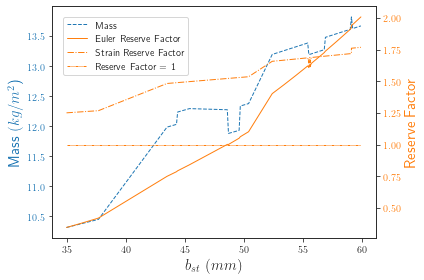

In [35]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel(r'$b_{st}$ $(mm)$')
ax1.set_ylabel(r'Mass $(kg/m^2$)', color=color)
ax1.plot(opt_df['bst'], opt_df['mass'], '--', color=color, linewidth = 1, label = 'Mass')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel(r'Reserve Factor', color=color)  # we already handled the x-label with ax1
ax2.plot(opt_df['bst'], opt_df['RF_euler']/1.2, color=color, linewidth = 1, label = 'Euler Reserve Factor')
ax2.plot(opt_df['bst'], opt_df['RF_mat'], '-.', color=color, linewidth = 1, label = 'Strain Reserve Factor')
ax2.plot(opt_df['bst'], opt_df['bst']*0+1, linestyle = (0, (3, 1, 1, 1, 1, 1)), linewidth = 1, color=color, label = 'Reserve Factor = 1')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

# ax1.spines['bottom'].set_position('zero')
# ax1.spines['left'].set_position('zero')
# ax2.spines['bottom'].set_position('zero')
# ax2.spines['left'].set_position('zero')
# sns.despine(offset=0, right = False)

axbox = ax1.get_position()
fig.legend(loc = (axbox.x0+0.02, axbox.y0+0.57))

plt.savefig(f'opt_stacking_10_60.eps')

In [36]:
print('\033[91mOptimal values')
best_bst = min_bst
best_tst = calc_tst(min_bst)
best_tsk = factor_calc(min_bst)*best_tst
best_mass = 1e6*calc_mass(min_bst)/bsk
print(f'bst = {best_bst:.2f} mm')
print(f'tst = {best_tst:.2f} mm')
print(f'tsk = {best_tsk:.2f} mm')
print(f'mass = {best_mass:.2f} kg/m^2')

print()

# euler_buckling_load = calc_Nxeuler(best_bst)(best_tst)
# material_faulire_load = calc_uts(best_tst, best_tsk, best_bst)
# print(f"Nx = {Nx:.2f} N/mm")
# print(f'UTS = {material_faulire_load:.2f} N/mm')
# print(f'Pcr = {euler_buckling_load:.2f} N/mm')

print()

print('\033[92mReal values')

rf_options = np.array(rf_options)
mass_options = np.array(mass_options)
best_index = int(np.argwhere(mass_options == mass_options[rf_options > 1.2].min()))

best_bst = bst_options_pass[best_index]
best_tsk = tsk_options_best[best_index]
best_tst = tst_options_best[best_index]
best_mass = mass_options[best_index]
best_rf = rf_options[best_index]
best_tst_stacking = tst_stacking[best_index]
best_tsk_stacking = tsk_stacking[best_index]

best_tsk_stacking_pc = np.array([int(i) for i in best_tsk_stacking.split('/')])
best_tsk_stacking_pc = '/'.join([str(round(i*100)) for i in (best_tsk_stacking_pc/best_tsk_stacking_pc.sum()).round(2)])
best_tst_stacking_pc = np.array([int(i) for i in best_tst_stacking.split('/')])
best_tst_stacking_pc = '/'.join([str(round(i*100)) for i in (best_tst_stacking_pc/best_tst_stacking_pc.sum()).round(2)])

print(f'bst = {best_bst:.1f} mm')
print(f'tst = {best_tst:.3f} mm')
print(f'tsk = {best_tsk:.3f} mm')
print(f'mass = {best_mass:.2f} kg/m^2')
print()
print(f"Nx = {Nx:.2f} N/mm")
print(f'UTS = {Nx_mat_options[best_index]:.2f} N/mm')
print(f'Pcr = {Nx_euler_options[best_index]:.2f} N/mm')
print()
print(f'RF = {best_rf:.2f}')
print(f'tsk stacking = {best_tsk_stacking} ; {best_tsk_stacking_pc}')
print(f'tst stacking = {best_tst_stacking}  ; {best_tst_stacking_pc}')

Optimal values
bst = 52.70 mm
tst = 2.20 mm
tsk = 5.03 mm
mass = 12.50 kg/m^2


Real values
bst = 48.7 mm
tst = 2.125 mm
tsk = 4.875 mm
mass = 11.88 kg/m^2

Nx = 1.74 N/mm
UTS = 2.65 N/mm
Pcr = 2.09 N/mm

RF = 1.20
tsk stacking = 19/16/4 ; 49/41/10
tst stacking = 10/4/3  ; 59/24/18


In [37]:
optimum_stacking(best_tsk, best_tst, best_bst)

C:\Users\timot\AppData\Local\Temp\ipykernel_13652\1586814729.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[x_str, e, n*t]], columns = ['seq', 'E', 't'], index = [i]))
C:\Users\timot\AppData\Local\Temp\ipykernel_13652\1586814729.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[x_str, e, n*t]], columns = ['seq', 'E', 't'], index = [i]))
C:\Users\timot\AppData\Local\Temp\ipykernel_13652\1586814729.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[x_str, e, n*t]], columns = ['seq', 'E', 't'], index = [i]))
C:\Users\timot\AppData\Local\Temp\ipykernel_13652\1586814729.py:47: FutureWarning: The frame.append method is deprecated 

,seqst,Est,tst,seqsk,Esk,tsk,Etbar,Nx_st,Nx_sk,Nx_mat,Nx_euler,mass,RF_st,RF_sk,RF_mat,RF_euler,pass
28,10/4/3,84.12,2.12,19/16/4,76.67,4.88,588.35,1.85,1.78,2.65,2.09,11.88,1.06,1.02,1.52,1.20,True


In [38]:
best_bst

48.70

In [39]:
f1, bskc, bsko = factor_calc(48.7 , True)
print(bskc, bsko)
Nx

132.4 47.599999999999994


1.74

In [40]:
1-11.88/13.9

0.15

In [41]:
bst = np.arange(10, 60, 0.001)
mass = [1e6*calc_mass(i)/bsk for i in bst]
tst = [calc_tst(i) for i in bst]
tsk = [i*factor_calc(j) for i,j in zip(tst, bst)]

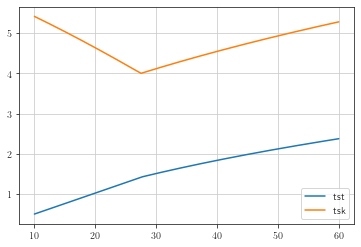

In [42]:
plt.plot(bst, tst, label = 'tst')
plt.plot(bst, tsk, label = 'tsk')
plt.legend()
plt.grid()

In [43]:
idx = np.argmin(np.abs(np.array(bst) - 43.5))
print(bst[idx])
print(tsk[idx])
stack([44,44,12], tsk[idx])

43.49999999998143
4.688239186191708


C:\Users\timot\AppData\Local\Temp\ipykernel_13652\1586814729.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[x_str, e, n*t]], columns = ['seq', 'E', 't'], index = [i]))
C:\Users\timot\AppData\Local\Temp\ipykernel_13652\1586814729.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[x_str, e, n*t]], columns = ['seq', 'E', 't'], index = [i]))
C:\Users\timot\AppData\Local\Temp\ipykernel_13652\1586814729.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[x_str, e, n*t]], columns = ['seq', 'E', 't'], index = [i]))
C:\Users\timot\AppData\Local\Temp\ipykernel_13652\1586814729.py:47: FutureWarning: The frame.append method is deprecated 

,seq,E,t
0,15/16/4,70.57,4.38
1,15/16/6,66.76,4.62
2,15/20/4,66.67,4.88
3,15/20/6,63.41,5.12
4,16/16/3,74.29,4.38
5,16/16/4,72.22,4.50
6,16/16/5,70.27,4.62
7,16/16/6,68.42,4.75
8,16/16/7,66.67,4.88
9,16/20/3,70.00,4.88


In [44]:
opt_df[(43 < opt_df.bst) & (opt_df.bst < 44 )]

,seqst,Est,tst,seqsk,Esk,tsk,Etbar,Nx_st,Nx_sk,Nx_mat,Nx_euler,mass,RF_st,RF_sk,RF_mat,RF_euler,pass,bst,RF
55,10/4/3,84.12,2.12,18/20/3,72.93,5.12,572.86,2.26,2.25,2.58,1.57,11.99,1.30,1.30,1.48,0.90,False,43.50,2.25
61,10/4/3,84.12,2.12,19/16/6,72.93,5.12,572.86,2.26,2.25,2.58,1.57,11.99,1.30,1.30,1.48,0.90,False,43.50,2.25
55,10/4/3,84.12,2.12,18/20/3,72.93,5.12,573.16,2.25,2.25,2.58,1.58,11.99,1.29,1.29,1.48,0.91,False,43.60,2.24
61,10/4/3,84.12,2.12,19/16/6,72.93,5.12,573.16,2.25,2.25,2.58,1.58,11.99,1.29,1.29,1.48,0.91,False,43.60,2.24
61,10/4/3,84.12,2.12,19/16/6,72.93,5.12,573.45,2.24,2.24,2.58,1.58,12.00,1.29,1.29,1.48,0.91,False,43.70,2.24
55,10/4/3,84.12,2.12,18/20/3,72.93,5.12,573.45,2.24,2.24,2.58,1.58,12.00,1.29,1.29,1.48,0.91,False,43.70,2.24
55,10/4/3,84.12,2.12,18/20/3,72.93,5.12,573.75,2.23,2.24,2.58,1.59,12.00,1.28,1.29,1.48,0.92,False,43.80,2.24
61,10/4/3,84.12,2.12,19/16/6,72.93,5.12,573.75,2.23,2.24,2.58,1.59,12.00,1.28,1.29,1.48,0.92,False,43.80,2.24
55,10/4/3,84.12,2.12,18/20/3,72.93,5.12,574.05,2.22,2.23,2.58,1.60,12.01,1.28,1.28,1.49,0.92,False,43.90,2.24
61,10/4/3,84.12,2.12,19/16/6,72.93,5.12,574.05,2.22,2.23,2.58,1.60,12.01,1.28,1.28,1.49,0.92,False,43.90,2.24
